In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from sklearnex import patch_sklearn
patch_sklearn()
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import clear_output
import shap


import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Hourly distribution

In [23]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)

house_consumption_columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_1', 
    'sub_metering_2',
    'sub_metering_3',
    # 'daily_energy_consumption_kwh'
]

df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


In [10]:
df.shape

(2053263, 43)

## Train test split

In [11]:

def get_season(x):
    seasons = []
    month = x.month
    
    for m in month:
    # Define the seasons based on months
        if 3 <= m <= 5:
            season = "Spring"
        elif 6 <= m <= 8:
            season = "Summer"
        elif 9 <= m <= 11:
            season = "Autumn"
        else:
            season = "Winter"

        seasons.append(season)

    return seasons


In [12]:
def get_weekend_feature(df:pd.DataFrame):
    day_of_week = df.index.day_of_week
    is_weekend = (day_of_week == 5) | (day_of_week ==6)
    df['is_weekend'] = is_weekend.astype(float)

    return df

def get_season_feature(df : pd.DataFrame):
    seasons = get_season(df.index)
    df['season'] = seasons
    df = pd.concat(
        [
            df,
            pd.get_dummies(df['season'])
        ],
        axis = 1
    )

    return df



In [13]:
raw_train_df = df.loc[:'31-12-2009']
raw_test_df = df.loc['2010']

# ------------ train df -------------------------------

# raw_train_df['daily_energy_consumption_kwh'] = raw_train_df['global_active_power']\
#     .groupby(
#         pd.Grouper(freq='1min')
#     ).sum()/(60)

# train_df = raw_train_df.dropna()

train_df = raw_train_df.groupby(pd.Grouper(freq = '1D')).mean()

train_df = get_weekend_feature(train_df)
train_df = get_season_feature(train_df)


# ------------ test df ----------------------------------

# raw_test_df['daily_energy_consumption_kwh'] = raw_test_df['global_active_power']\
#     .groupby(
#         pd.Grouper(freq='1min')
#     ).sum()/(60)

# test_df = raw_test_df.dropna()

test_df = raw_test_df.groupby(pd.Grouper(freq = '1D')).mean()

test_df = get_weekend_feature(test_df)
test_df = get_season_feature(test_df)


### Selecting columns

In [14]:

corr = train_df.corr()

In [27]:
weather_columns = corr\
    .columns\
    .difference(house_consumption_columns)\
    .union(['global_active_power'])

In [25]:
abs(corr['global_active_power'].loc[weather_columns]).sort_values().dropna().tail(10)

ww            0.142950
ch            0.171875
cm            0.188510
is_weekend    0.210917
vv            0.293237
u             0.366748
Winter        0.416461
td            0.478772
Summer        0.517790
t             0.558997
Name: global_active_power, dtype: float64

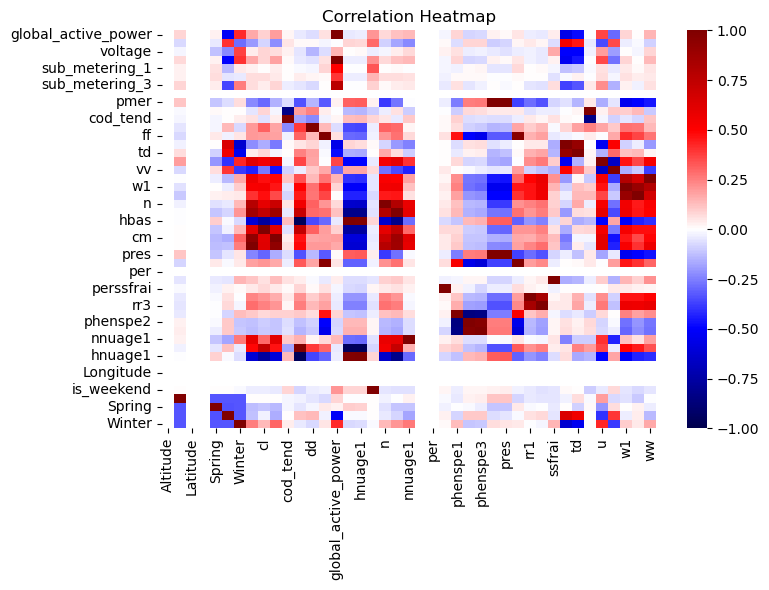

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr[weather_columns], cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig("img/correlation_heatmap.png")
plt.show()

## Selecting features

In [32]:
selected_columns = corr['global_active_power'].abs() > 1e-1
selected_columns[house_consumpion_columns] = False
selected_columns = selected_columns[selected_columns].index

selected_columns

Index(['t', 'td', 'u', 'vv', 'ww', 'nbas', 'cm', 'ch', 'nnuage1', 'is_weekend',
       'Summer', 'Winter'],
      dtype='object')

## Optimization methods

### Choosing model- cross validation

In order to determine the optimal model for testing, we will train various models and select the one that demonstrates the highest average performance during the validation period.

In [85]:

def train(
    train_df : pd.DataFrame, 
    target: pd.Series,
    n_splits : int,
    models : List[BaseEstimator] = [
        SVR(kernel = 'rbf'), 
        LinearRegression(), 
        Lasso(), 
        DecisionTreeRegressor(max_depth = 4),
        RandomForestRegressor(n_estimators = 30, max_depth = 4), 
        KNeighborsRegressor()
    ]
):
    """
    Train multiple regression models and evaluate their performance using cross-validation.

    Parameters:
    - train_df (pd.DataFrame): DataFrame containing the training features.
    - target (pd.Series): Series containing the target variable.
    - n_splits (int): Number of splits for cross-validation.
    - models (List[BaseEstimator], optional): List of regression models to train. Defaults to a list containing SVR, LinearRegression, Lasso, RandomForestRegressor, and MLPRegressor.

    Returns:
    - results (Dict[str, List[float]]): Dictionary containing the validation scores for each model.
    """
    
    results = {type(x).__name__ : [] for x in models}
    splitter = splitter = KFold(n_splits)

    for model in models:

        model_name : str = type(model).__name__
        
        clear_output()
        print(f"Running model selection for {model_name}")

        splits = splitter.split(train_df)

        for idx_train, idx_val in tqdm(splits, total = n_splits):
            X_train = train_df.iloc[idx_train]
            y_train = target.iloc[idx_train]

            X_val = train_df.iloc[idx_val]
            y_val = target.iloc[idx_val]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)

            validation_score = r2_score(y_val, y_pred)

            results[model_name].append(validation_score)

    return results

In [86]:
selected_columns = selected_columns.union(pd.Index(['is_weekend', 'Autumn', 'Spring']))

In [87]:
# selected_columns = [
#        'is_weekend', 'Autumn', 'Spring', 'Summer', 'Winter', 't', 'td',
# ]

In [88]:
X_train = train_df[selected_columns]\
    .dropna()

y_train = train_df['global_active_power']

intersection_idx = y_train.index.intersection(X_train.index)

y_train = y_train.reindex(index = intersection_idx)
X_train = X_train.reindex(index = intersection_idx)

# ----------- test ---------------------

X_test = test_df[selected_columns].dropna()
y_test = test_df['global_active_power']
intersection_idx = y_test.index.intersection(X_test.index)

y_test = y_test.reindex(index = intersection_idx)
X_test = X_test.reindex(index = intersection_idx)

In [89]:

train_results = train(
    X_train,
    y_train,
    5,
    # models = [LinearRegression(), KNeighborsRegressor()]
)

Running model selection for KNeighborsRegressor


100%|██████████| 5/5 [00:00<00:00, 117.78it/s]


In [90]:
pd.DataFrame(train_results)

,SVR,LinearRegression,Lasso,DecisionTreeRegressor,RandomForestRegressor,KNeighborsRegressor
0,0.039049,0.360636,0.036862,0.319725,0.344071,-0.074605
1,-0.094603,0.354883,-0.089389,0.196774,0.298330,-0.189757
2,-0.099040,0.334440,-0.090525,0.303761,0.363336,-0.241653
3,-0.235245,0.005500,-0.172361,0.008925,0.043035,-0.514230
4,0.219878,0.516663,0.192466,0.415356,0.507102,-0.003692


In [91]:
pd.DataFrame(train_results).mean()

SVR                     -0.033992
LinearRegression         0.314424
Lasso                   -0.024589
DecisionTreeRegressor    0.248908
RandomForestRegressor    0.311175
KNeighborsRegressor     -0.204787
dtype: float64

In [92]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [93]:
y_pred = model.predict(X_test)

r2_score(y_test, y_pred)

0.3217762504561701

## CHANGE HERE

As observed, weather features alone did not perform well during validation, as indicated by negative r2 scores. We will enhance them by incorporating features derived from previous target values.

## Experiment 2 - consumption features

In [94]:
frequencies = [1, 7]

X_train2 = X_train.copy()
y_train2 = y_train.copy()

X_test2 = X_test.copy()
y_test2 = y_test.copy()

for freq in frequencies:
    X_train2[f'avg_consumption_d-{freq}'] = y_train2.rolling(freq)\
        .mean()\
        .shift(1)
    
    X_train2[f'diff_consumption_d-{freq}'] = y_train2.diff(freq)\
        .shift(1)
    
    X_test2[f'avg_consumption_d-{freq}'] = y_test2.rolling(freq)\
        .mean()\
        .shift(1)
    
    X_test2[f'diff_consumption_d-{freq}'] = y_test2.diff(freq)\
        .shift(1)
    
X_train2 = X_train2.dropna()
y_train2 = y_train2.reindex(index = X_train2.index)

X_test2 = X_test2.dropna()
y_test2 = y_test2.reindex(index = X_test2.index)

# 

In [95]:
X_train2.corrwith(y_train2)

Autumn                  0.084846
Spring                  0.029050
Summer                 -0.519147
Winter                  0.412174
ch                      0.168038
cm                      0.184590
is_weekend              0.216206
nbas                    0.118473
nnuage1                 0.138931
t                      -0.562901
td                     -0.483442
u                       0.367039
vv                     -0.297894
ww                      0.140099
avg_consumption_d-1     0.629710
diff_consumption_d-1    0.154342
avg_consumption_d-7     0.677523
diff_consumption_d-7    0.221487
dtype: float64

In [96]:
X_train2

,Autumn,Spring,Summer,Winter,ch,cm,is_weekend,nbas,nnuage1,t,td,u,vv,ww,avg_consumption_d-1,diff_consumption_d-1,avg_consumption_d-7,diff_consumption_d-7
date,,,,,,,,,,,,,,,,,,
2007-01-09,0,0,0,1,47.875000,50.7500,0.0,5.875000,2.250000,285.8375,283.3125,84.875,18375.0,6.625,1.555687,0.035342,1.379744,-0.353344
2007-01-10,0,0,0,1,35.458333,31.3750,0.0,4.041667,3.666667,283.0625,280.3375,83.125,19625.0,9.250,1.235469,-0.320217,1.430323,0.354056
2007-01-11,0,0,0,1,35.916667,41.0625,0.0,4.333333,4.395833,280.7000,278.4750,85.875,18875.0,14.000,1.449482,0.214012,1.537486,0.750142
2007-01-12,0,0,0,1,29.250000,37.6250,0.0,5.125000,4.625000,282.8750,280.4500,85.000,15250.0,2.125,1.483989,0.034507,1.441695,-0.670539
2007-01-13,0,0,0,1,60.000000,61.0000,1.0,7.000000,3.437500,283.9750,282.3125,89.500,19625.0,18.625,1.003222,-0.480767,1.321226,-0.843282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,0,0,0,1,19.812500,28.0625,1.0,3.187500,2.187500,277.2625,274.6875,83.500,20800.0,5.875,1.498915,0.033053,1.301775,-0.015788
2009-12-28,0,0,0,1,17.750000,22.0000,0.0,2.000000,3.250000,276.0750,275.0750,93.250,13750.0,2.000,1.471781,-0.027133,1.399269,0.682459
2009-12-29,0,0,0,1,41.250000,45.6250,0.0,6.875000,3.125000,281.5500,280.5000,93.250,10900.0,32.500,1.443715,-0.028066,1.417852,0.130085


In [97]:
results_experiment2 = train(
    X_train2,
    y_train2,
    5,
)

Running model selection for KNeighborsRegressor


100%|██████████| 5/5 [00:00<00:00, 121.65it/s]


In [98]:
pd.DataFrame(results_experiment2)

,SVR,LinearRegression,Lasso,DecisionTreeRegressor,RandomForestRegressor,KNeighborsRegressor
0,0.029009,0.497184,0.031642,0.326079,0.516358,-0.083641
1,-0.131409,0.474917,-0.125777,0.373066,0.407246,-0.246028
2,-0.085092,0.629245,-0.076460,0.509267,0.590809,-0.220818
3,-0.228073,0.237737,-0.171712,0.095287,0.229375,-0.550586
4,0.222245,0.604903,0.199592,0.512277,0.600902,0.047066


In [99]:
pd.DataFrame(results_experiment2).mean()

SVR                     -0.038664
LinearRegression         0.488797
Lasso                   -0.028543
DecisionTreeRegressor    0.363195
RandomForestRegressor    0.468938
KNeighborsRegressor     -0.210802
dtype: float64

In [100]:
model = LinearRegression()
model.fit(X_train2, y_train2)

LinearRegression()

In [101]:
y_pred2 = model.predict(X_test2)

In [103]:
r2_score(y_test2, y_pred2)

0.4870295479959569

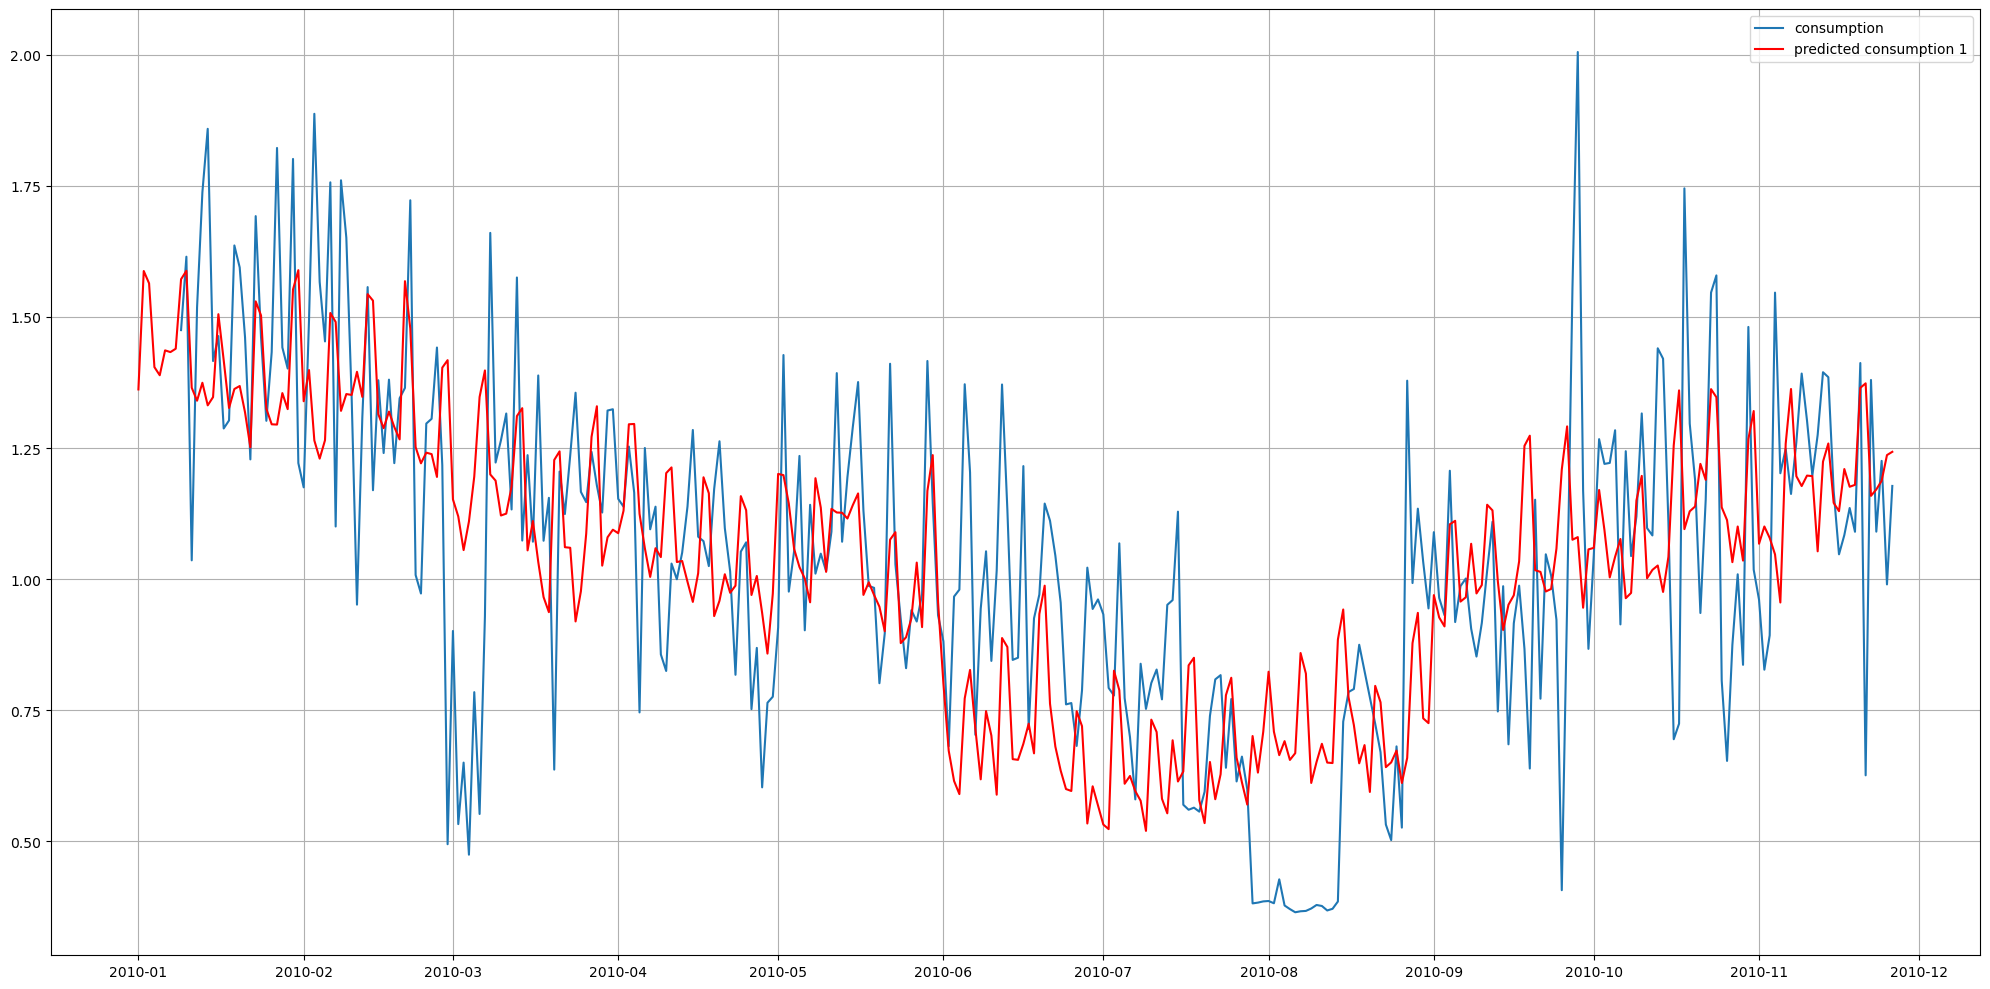

In [105]:
plt.figure( figsize=[20,10])
plt.plot(y_test2, label  ='consumption')
plt.plot(pd.Series(y_pred, index = y_test.index), label = 'predicted consumption 1', color = 'red')
# plt.plot(pd.Series(y_pred2, index = y_test2.index), label = 'predicted consumption 2', color = 'green')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("img/predictions.png")

## LSTM

In [154]:
X_train3 = X_train2.loc[:'2008']
y_train3 = y_train2.loc[:'2008']


In [155]:
X_val3 = X_train2.loc['2009':]
y_val3 = y_train2.loc['2009':]

In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from torcheval.metrics import R2Score
metric = R2Score()

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare the data
# Assuming X is a DataFrame and y is a Series
X_tensor = torch.tensor(X_train3.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train3.values, dtype=torch.float32).view(-1, 1)

X_tensor_val = torch.tensor(X_train3.values, dtype=torch.float32)
y_tensor_val = torch.tensor(y_train3.values, dtype=torch.float32).view(-1, 1)

# Define hyperparameters
input_size = X_train2.shape[1]  # Number of features
hidden_size = 2
num_layers = 2
output_size = 1  # Assuming y is a single output
batch_size = 1
num_epochs = 100
learning_rate = 0.001

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_tensor_val, y_tensor_val)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    predictions = torch.Tensor([])
    y_true = torch.Tensor([])
    for batch_X, batch_y in data_loader:
        # Forward pass
        outputs = model(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for X, y in val_data_loader:
        y_pred = model(X.unsqueeze(1))
        predictions = torch.concat([y_pred, predictions])
        y_true = torch.concat([y_true, y])

    metric.update(predictions, y_true)
    r2 = metric.compute()

    if (epoch+1) % 1 == 0:
        clear_output()
        print(f'Epoch [{epoch+1}/{num_epochs}], R2: {r2.item():.4f}')

100%|██████████| 100/100 [04:05<00:00,  2.45s/it]

Epoch [100/100], R2: -0.3449
